<a href="https://colab.research.google.com/github/kittimaxz/Project_BoneAge/blob/main/BoneAgePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def dataset_path(*rel_path):
    return os.path.join('/content/drive/My Drive/Project_Boneage', *rel_path);

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
class BoneAgeTrainingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage zscore'][idx])).double()

In [6]:
class BoneAgeValidatingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage zscore'][idx])).double()

In [7]:
class BoneAgePredictor(nn.Module):
    def __init__(self):
        super(BoneAgePredictor, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(1, 4, 3)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.batch1 = nn.BatchNorm2d(4)
        # Layer 2
        self.conv2 = nn.Conv2d(4, 8, 3)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.batch2 = nn.BatchNorm2d(8)
        # Layer 3
        self.conv3 = nn.Conv2d(8, 16, 3)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.batch3 = nn.BatchNorm2d(16)
        # Layer 4
        self.conv4 = nn.Conv2d(16, 16, 3)
        nn.init.kaiming_normal_(self.conv4.weight)
        self.batch4 = nn.BatchNorm2d(16)
        # Layer 5
        self.conv5 = nn.Conv2d(16, 16, 3)
        nn.init.kaiming_normal_(self.conv5.weight)
        self.batch5 = nn.BatchNorm2d(16)
        # Fully connected
        self.fc1 = nn.Linear(576, 24)
        self.fc2 = nn.Linear(24, 1)

    def forward(self, x):
        # Layer 1
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        # Layer 2
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        # Layer 3
        x = F.relu(self.batch3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        # Layer 4
        x = F.relu(self.batch4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        # Layer 5
        x = F.relu(self.batch5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        # Pooling
        x = x.view(-1, 576)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.l1_loss(output.view(-1), target)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [9]:
def val(model, device, loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
trainig_data_loader = torch.utils.data.DataLoader(
    BoneAgeTrainingDataset('train_z.csv', 'boneage_training_dataset'),
    batch_size=64, shuffle=True, **kwargs)
validating_data_loader = torch.utils.data.DataLoader(
    BoneAgeValidatingDataset('validation_z.csv', 'boneage_validation_dataset'),
    batch_size=64, shuffle=True, **kwargs)

In [11]:
model = BoneAgePredictor().double().to(device)
print(model)
optimizer = optim.Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2, min_lr=1e-3, verbose=True)

BoneAgePredictor(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=576, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=1, bias=True)
)


In [12]:
for epoch in range(1, 4):
        train(model, device, trainig_data_loader, optimizer, epoch)
        train_loss = val(model, device, trainig_data_loader,'Train')
        val_loss = val(model, device, validating_data_loader,'Validate')
        scheduler.step(val_loss)

Train Epoch: 1 [0/10089 (0%)]	Loss: 0.832555
Train Epoch: 1 [64/10089 (1%)]	Loss: 0.857574
Train Epoch: 1 [128/10089 (1%)]	Loss: 0.932253
Train Epoch: 1 [192/10089 (2%)]	Loss: 0.945262
Train Epoch: 1 [256/10089 (3%)]	Loss: 0.930528
Train Epoch: 1 [320/10089 (3%)]	Loss: 0.770628
Train Epoch: 1 [384/10089 (4%)]	Loss: 0.855036
Train Epoch: 1 [448/10089 (4%)]	Loss: 0.845746
Train Epoch: 1 [512/10089 (5%)]	Loss: 0.784871
Train Epoch: 1 [576/10089 (6%)]	Loss: 0.787687
Train Epoch: 1 [640/10089 (6%)]	Loss: 0.877971
Train Epoch: 1 [704/10089 (7%)]	Loss: 0.730117
Train Epoch: 1 [768/10089 (8%)]	Loss: 0.554744
Train Epoch: 1 [832/10089 (8%)]	Loss: 0.780711
Train Epoch: 1 [896/10089 (9%)]	Loss: 0.811632
Train Epoch: 1 [960/10089 (9%)]	Loss: 0.801401
Train Epoch: 1 [1024/10089 (10%)]	Loss: 0.799214
Train Epoch: 1 [1088/10089 (11%)]	Loss: 0.733927
Train Epoch: 1 [1152/10089 (11%)]	Loss: 0.650201
Train Epoch: 1 [1216/10089 (12%)]	Loss: 0.781102
Train Epoch: 1 [1280/10089 (13%)]	Loss: 0.816013
Train 

In [15]:
val_loss = []
train_loss = []
train_loss.np.array(train_loss)
val_loss.np.array(val_loss)

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_loss,label="validation")
plt.plot(train_loss,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

AttributeError: ignored

AttributeError: ignored

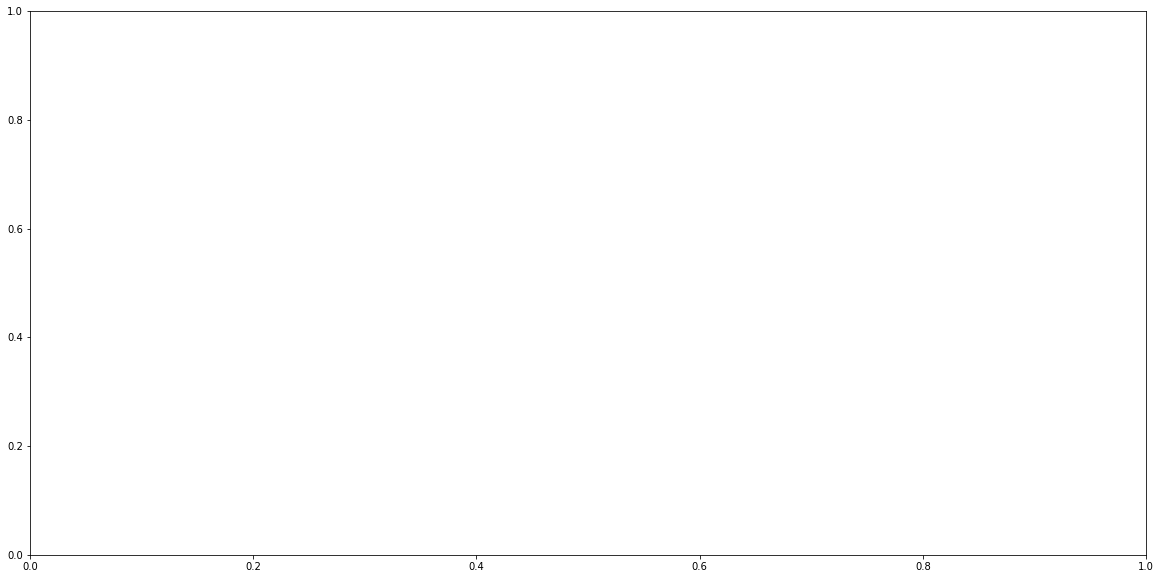

In [14]:
fig,ax = plt.subplots( figsize=(20,10))
ax.plot(train_loss.train_loss['train_loss'])
ax.plot(val_loss.val_loss['val_loss'])
plt.title('Model Error')
plt.ylabel('error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
ax.grid(color='black')
plt.show()

In [ ]:
# check = torch.rand(5,1,256,256)
# model = BoneAgePredictor();
# print(model.forward(check).size())

In [ ]:
# check = pd.read_csv(dataset_path('boneage-training-dataset.csv'));
# print(check)
# print(check['boneage'][0])
# print(check['id'][1])
# check = Image.open(dataset_path('boneage-training-dataset',str(check['id'][1])+'.png')).resize((256,256))
# print(check)
# # check = transform(check)
# # print(check.size())
# # check = torch.from_numpy(np.array(check['boneage'][0]))
# # print(check)